In [1]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('E:\data\Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')


In [3]:
#将仅用于标示的特征去掉
data=data.drop(['Order','Property Name','Property Id','Address 1 (self-reported)','BBL - 10 digits'],axis=1)

In [4]:
#将not available 转为空值
data=data.replace('Not Available',np.nan)
#查看空值情况
na_percent=(data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
#step 3.1扔掉缺失率超过0.5的特征
nap=na_percent.to_frame()
data=data.drop(nap[nap>0.5].dropna().index.tolist(),axis=1)  #axis=1 将包含这些列名的列扔掉，注意对测试集做相同处理
#对于剩余的空值，用众数填充
data=data.fillna(data.mode().iloc[0])

In [5]:
#设立需要进行字符转数字的列表s2n_list
s2n_list=['(ft','kBtu','Tons','kWh','therms','gal','Score']
for c in data.columns.tolist():
    if any([s in c for s in s2n_list]):
        data[c]=data[c].astype(float)

In [6]:
#接下来需要减少存储开支
#首先是将float64转为float32,将内存用量直接从5.4M降至3.9M
#这是类型为float64的列
cl_float=data.select_dtypes(include=['float']).columns
data[cl_float]=data[cl_float].apply(pd.to_numeric,downcast='float')

In [7]:
#将非负整型类转为uint进行存储
cl_int=data.select_dtypes(include=['int']).columns.tolist()
data[cl_int]=data[cl_int].apply(pd.to_numeric,downcast='unsigned')

In [8]:
#将反复出现字符串类型的列转为分类category，
cl_string=data.select_dtypes(include=['object']).columns.tolist()

for c in cl_string:
    unique_num=len(data[c].unique())
    total_num=len(data[c])
    if unique_num/total_num<0.33:
        data[c]=data[c].astype('category')

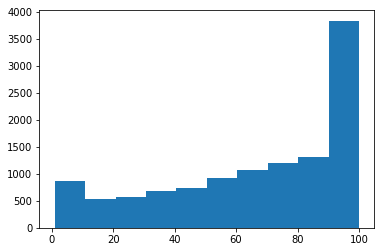

In [9]:
#观察目标值的分布
plt.hist(data['ENERGY STAR Score'].dropna())
plt.show()

In [10]:
#data分为数值部分和数组部分
data_num0=data.select_dtypes(include='number')
data_str=data.drop(data_num0.columns,axis=1)

In [11]:
#将两部分分别进行主要特征提取
#在这之前先把price部分提取出来
data_score=data['ENERGY STAR Score']
data_num=data_num0.drop(['ENERGY STAR Score'],axis=1)   #df是扔掉目标值的data
from sklearn import preprocessing
mms=preprocessing.MinMaxScaler()
data_num.iloc[:,:]=mms.fit_transform(data_num.values)  

#数据部分主要特征提取,lnum用于存储各个属性与目标变量的互信息
import sklearn.metrics 
from sklearn.metrics import normalized_mutual_info_score 
lnum=pd.DataFrame(index=['score'])                         #l为各个属性与目标变量的关联程度
for c in data_num.columns:
    lnum.loc['score',c]=normalized_mutual_info_score(data_num[c],data_score.values)
lnum_sort=lnum.sort_values(by='score',axis=1,ascending=False)
data_num=data_num[lnum[lnum>0.3].dropna(axis=1).columns.tolist()]

#字符部分主要特征提取
lstr=pd.DataFrame(index=['score'])
for c in data_str.columns:
    lstr.loc['score',c]=normalized_mutual_info_score(data_str[c],data_score.values)
lstr_sort=lstr.sort_values(by='score',axis=1,ascending=False)
data_str=data_str[lstr[(lstr>0.05) & (lstr<0.3)].dropna(axis=1).columns.tolist()]
#对字符串部分进行正则化处理


#将两部分合并成为新的data
data=pd.concat([data_num,data_str],axis=1)
data_all=pd.concat([data,data_score],axis=1)

In [12]:
lstr_sort

,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Street Number,Release Date,Street Name,List of All Property Use Types at Property,Postal Code,NTA,Primary Property Type - Self Selected,Largest Property Use Type,Parent Property Id,Parent Property Name,Metered Areas (Water),Metered Areas (Energy),Borough,Water Required?,DOF Benchmarking Submission Status
score,0.65356,0.649024,0.463176,0.411092,0.366207,0.173762,0.14999,0.118676,0.073089,0.072695,0.067215,0.067197,0.015534,0.014081,0.009883,0.002407,0.000006


In [13]:
lnum_sort

,Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Natural Gas Use (kBtu),Largest Property Use Type - Gross Floor Area (ft²),Property GFA - Self-Reported (ft²),DOF Gross Floor Area,Weather Normalized Site Natural Gas Use (therms),Total GHG Emissions (Metric Tons CO2e),Latitude,Direct GHG Emissions (Metric Tons CO2e),...,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Census Tract,Weather Normalized Site Electricity Intensity (kWh/ft²),Year Built,Weather Normalized Site Natural Gas Intensity (therms/ft²),Council District,Number of Buildings - Self-reported,Community Board,Occupancy
score,0.655048,0.637734,0.616805,0.607325,0.606955,0.604704,0.601117,0.594771,0.567791,0.548709,...,0.3952,0.379166,0.27376,0.186424,0.11964,0.064941,0.055916,0.043451,0.02852,0.027003


In [14]:
#观察单变量关于目标变量的分布，这里以property
data_all_property=data.groupby('List of All Property Use Types at Property')['List of All Property Use Types at Property'].count()

In [15]:
#选取该属性下最多的5个
s=data_all_property.sort_values(ascending=False)[:5].index

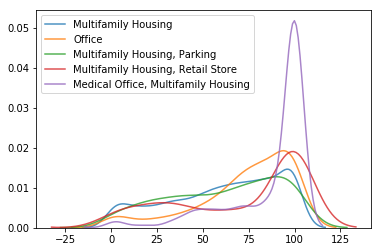

In [16]:
%matplotlib inline
#分别画出以上5类索引对应的score分布
#可以看出office的分布明显区别于multifamily的分布
for i in s.tolist():
    subset=data_all[data_all['List of All Property Use Types at Property']==i]
    sns.kdeplot(subset['ENERGY STAR Score'],label=i,shade=False,alpha=0.8)

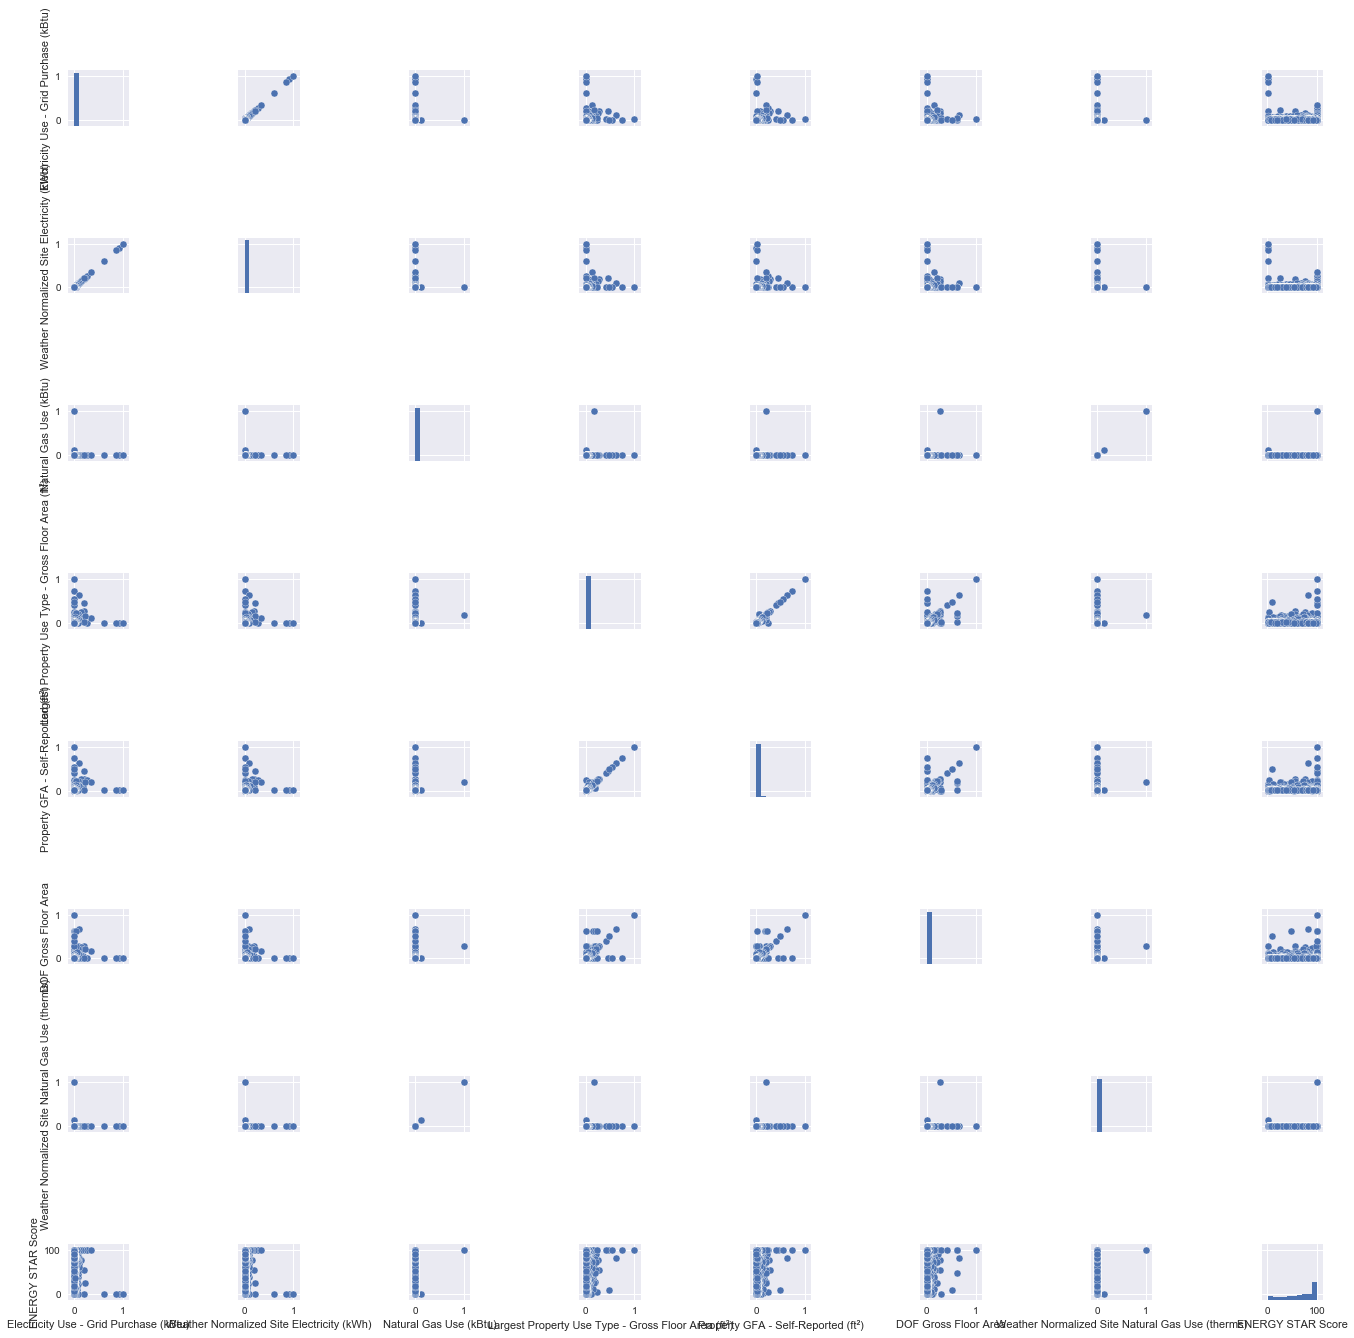

In [17]:
#查看数据类型主要属性的pairplot,可以看到其中几个属性关于score的图与score的直方图非常接近（最后一列）
sns.set()
cols=lnum_sort.iloc[:,:7].columns.tolist()+['ENERGY STAR Score']
sns.pairplot(data_all[cols], size = 2.3)


In [18]:
#我们可以发现将共线性的特征进行删除，相关系数大于0.6
data_corr=data.corr()
cl=[]                                #用于存储需要扔掉的共线性特征
for i in range(data_corr.shape[0]-1):
    for j in range(i):
        item=data_corr.iloc[i+1:i+2,j:j+1]
        a=abs(item.values)
        if a>=0.6:
            cl=cl+item.columns.tolist()
cl=list(set(cl))                    #去除重复元素
            

In [19]:
#将共线性特征删除
data.drop(cl,axis=1,inplace=True)

In [20]:
#data分为数值部分和字符部分,并对字符部分进行独热编码
data_num=data.select_dtypes(include='number')
data_str=data.drop(data_num.columns,axis=1)
data_str=pd.get_dummies(data_str)
data_str.shape


(11746, 1556)

In [21]:
# #稀疏矩阵主成分表达式
# from sklearn.decomposition import SparsePCA
# spca=SparsePCA(n_components=30)
# spca.fit(data_str)
# data_str=spca.transform(data_str)
data=pd.concat([data_num,data_str],axis=1)

In [22]:
#训练集测试集划分，其实第一步就应该做，方便起见
from sklearn.cross_validation import train_test_split
trainx,testx,trainy,testy=train_test_split(data,data_score,test_size=0.3)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
#定义用于性能检验的函数
# def mae(y,ypred):
#     a=np.mean(abs(y-ypred))
#     return a 
def model_mae(model):
    model.fit(trainx.values,trainy.values)
    train_pred=model.predict(trainx.values)
    test_pred=model.predict(testx.values)
    train=np.mean(abs(trainy-train_pred))
    test=np.mean(abs(testy-test_pred))
    return train,test

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

tra=[]
tsa=[]
for i in range(10):
    model=GradientBoostingRegressor(n_estimators=100+10*i)
    train,test=model_mae(model)
    tra.append(train)
    tsa.append(test)


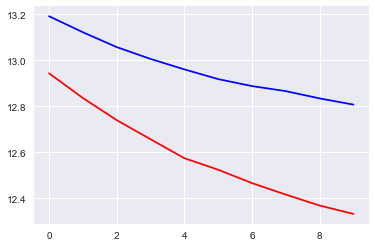

In [32]:
tra=np.array(tra)
tsa=np.array(tsa)
plt.plot(tra,color='r')
plt.plot(tsa,color='b')

In [ ]:
#可以看到收敛速率较慢，可能原因有：
#利用互信息删除特征的阈值可能较高，导致准确度下降
#空值填充采用的是众数，可考虑对数值部分采用中位数填充